In [58]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from sklearn import set_config
set_config(display='diagram')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.ensemble import RandomForestRegressor

file_path = "Resources/cleaned_airbnb_dataset2.csv"
df =  pd.read_csv(file_path)
df.head(10)

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total
0,958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.000,1.000,1,30,37.769,-122.434,217,97.000,170.000,100.000,270.000
1,3850,4921,t,House,Private room,Inner Sunset,94131,2,1.000,1.000,1,5,37.754,-122.458,160,94.000,99.000,10.000,109.000
2,5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.000,1.000,30,60,37.745,-122.421,111,98.000,235.000,100.000,335.000
3,7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,60,37.767,-122.453,18,86.000,65.000,50.000,115.000
4,8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,90,37.765,-122.452,8,93.000,65.000,50.000,115.000
5,8339,24215,f,House,Entire home/apt,Western Addition,94117,4,2.000,1.500,6,1125,37.775,-122.436,28,97.000,875.000,225.000,1100.000
6,8739,7149,t,Condominium,Private room,Mission,94110,3,1.000,1.000,1,14,37.759,-122.422,704,98.000,139.000,50.000,189.000
7,9225,29674,t,House,Private room,Potrero Hill,94107,2,1.000,1.000,1,365,37.763,-122.405,511,94.000,135.000,50.000,185.000
8,10251,35199,t,House,Entire home/apt,Mission,94110,4,2.000,1.000,30,60,37.759,-122.413,337,96.000,225.000,100.000,325.000
9,10578,37049,f,Apartment,Entire home/apt,Nob Hill,94109,2,0.000,1.000,30,180,37.791,-122.415,18,99.000,120.000,75.000,195.000


In [59]:
# Show summary stats for price column
df['price'].describe()

count    7815.000
mean      226.942
std       419.616
min         0.000
25%        99.000
50%       150.000
75%       245.000
max     10000.000
Name: price, dtype: float64

In [60]:
# Check for prices < 1
df[df['price'] < 1]

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total
3715,20331804,17536951,t,Condominium,Private room,Bernal Heights,94110,2,1.000,1.000,4,21,37.745,-122.420,32,96.000,0.000,50.000,50.000


In [61]:
# Drop the row with index 3715 and confirm its removal:
df.drop([3715], inplace = True)
df[df['price'] <= 1]

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total


In [62]:
# Check the proportion of listings that belong to each room type class
df['room_type'].value_counts(normalize=True)

Entire home/apt   0.578
Private room      0.365
Shared room       0.031
Hotel room        0.026
Name: room_type, dtype: float64

In [63]:
# Drop 'shared room' and 'hotel room' listings from the data frame
df = df[(df['room_type'] == 'Entire home/apt') | (df['room_type'] == 'Private room')]
df['room_type'].value_counts(normalize=True)

Entire home/apt   0.613
Private room      0.387
Name: room_type, dtype: float64

In [64]:
# Compute the proportion of listings that belong to each property type category
print(df['property_type'].value_counts(normalize=True))
print(df['property_type'].describe())

Apartment            0.403
House                0.294
Condominium          0.115
Guest suite          0.078
Boutique hotel       0.028
Townhouse            0.019
Hotel                0.015
Loft                 0.011
Serviced apartment   0.011
Guesthouse           0.006
Aparthotel           0.005
Other                0.003
Bed and breakfast    0.002
Bungalow             0.002
Hostel               0.002
Cottage              0.002
Resort               0.002
Villa                0.001
Castle               0.001
Cabin                0.000
Tiny house           0.000
Earth house          0.000
Hut                  0.000
In-law               0.000
Dome house           0.000
Camper/RV            0.000
Name: property_type, dtype: float64
count          7372
unique           26
top       Apartment
freq           2972
Name: property_type, dtype: object


In [65]:
# Add a column that shows the proportion of listings represented by each property type
df["property_type_freq"] = 1
df["property_type_freq"] = df.groupby('property_type').transform('count').div(len(df))
df.head()

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total,property_type_freq
0,958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.000,1.000,1,30,37.769,-122.434,217,97.000,170.000,100.000,270.000,0.403
1,3850,4921,t,House,Private room,Inner Sunset,94131,2,1.000,1.000,1,5,37.754,-122.458,160,94.000,99.000,10.000,109.000,0.294
2,5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.000,1.000,30,60,37.745,-122.421,111,98.000,235.000,100.000,335.000,0.403
3,7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,60,37.767,-122.453,18,86.000,65.000,50.000,115.000,0.403
4,8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,90,37.765,-122.452,8,93.000,65.000,50.000,115.000,0.403


In [66]:
# To simplify our model and improve its predictive utility, we could discard property types with freq < 3%.
# Drop property types with normalized frequencies less than 3% and confirm the change
df = df[(df['property_type_freq'] >= 0.03)]

print(df['property_type'].value_counts(normalize=True))
print('\n')
print(df['property_type'].describe())

Apartment     0.453
House         0.330
Condominium   0.130
Guest suite   0.087
Name: property_type, dtype: float64


count          6562
unique            4
top       Apartment
freq           2972
Name: property_type, dtype: object


In [67]:
# Drop property_type_freq from dataframe and confirm its removal
df.drop('property_type_freq', axis=1, inplace=True)
df.dtypes

room_id                   int64
host_id                   int64
host_is_superhost        object
property_type            object
room_type                object
neighborhood             object
zipcode                   int64
accommodates              int64
bedrooms                float64
bathrooms               float64
minimum_nights            int64
maximum_nights            int64
latitude                float64
longitude               float64
reviews                   int64
review_scores_rating    float64
price                   float64
cleaning_fee            float64
total                   float64
dtype: object

In [68]:
# Compute the normalized frequency of each neighborhood in the dataframe
print(df['neighborhood'].value_counts(normalize=True))
print('\n')
print(df['neighborhood'].describe())

Mission                 0.104
Western Addition        0.075
South of Market         0.074
Castro/Upper Market     0.060
Bernal Heights          0.056
Haight Ashbury          0.049
Downtown/Civic Center   0.049
Noe Valley              0.046
Outer Sunset            0.043
Nob Hill                0.036
Potrero Hill            0.032
Inner Richmond          0.030
Bayview                 0.027
Excelsior               0.027
Outer Richmond          0.026
Marina                  0.026
Inner Sunset            0.025
Outer Mission           0.024
Pacific Heights         0.021
Russian Hill            0.021
West of Twin Peaks      0.020
Parkside                0.018
North Beach             0.018
Ocean View              0.016
Financial District      0.012
Visitacion Valley       0.012
Twin Peaks              0.010
Glen Park               0.009
Chinatown               0.008
Lakeshore               0.008
Crocker Amazon          0.006
Seacliff                0.003
Presidio Heights        0.003
Diamond He

In [69]:
# To help our model's performance and predictive utility, we could use freq = 2% as a cut-off.
df["neigh_freq"] = 1
df["neigh_freq"] = df.groupby('neighborhood').transform('count').div(len(df))
df.head()

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total,neigh_freq
0,958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.000,1.000,1,30,37.769,-122.434,217,97.000,170.000,100.000,270.000,0.075
1,3850,4921,t,House,Private room,Inner Sunset,94131,2,1.000,1.000,1,5,37.754,-122.458,160,94.000,99.000,10.000,109.000,0.025
2,5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.000,1.000,30,60,37.745,-122.421,111,98.000,235.000,100.000,335.000,0.056
3,7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,60,37.767,-122.453,18,86.000,65.000,50.000,115.000,0.049
4,8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,90,37.765,-122.452,8,93.000,65.000,50.000,115.000,0.049


In [70]:
df = df[(df['neigh_freq'] >= 0.02)]
print(df['neighborhood'].value_counts(normalize=True))
print('\n')
print(df['neighborhood'].describe())

Mission                 0.119
Western Addition        0.086
South of Market         0.085
Castro/Upper Market     0.069
Bernal Heights          0.064
Downtown/Civic Center   0.056
Haight Ashbury          0.056
Noe Valley              0.053
Outer Sunset            0.049
Nob Hill                0.041
Potrero Hill            0.036
Inner Richmond          0.034
Bayview                 0.031
Excelsior               0.031
Outer Richmond          0.030
Marina                  0.030
Inner Sunset            0.029
Outer Mission           0.028
Pacific Heights         0.024
Russian Hill            0.024
West of Twin Peaks      0.023
Name: neighborhood, dtype: float64


count        5732
unique         21
top       Mission
freq          684
Name: neighborhood, dtype: object


In [71]:
# Drop neigh_freq from dataframe and confirm its removal
df.drop('neigh_freq', axis=1, inplace=True)
df.dtypes

room_id                   int64
host_id                   int64
host_is_superhost        object
property_type            object
room_type                object
neighborhood             object
zipcode                   int64
accommodates              int64
bedrooms                float64
bathrooms               float64
minimum_nights            int64
maximum_nights            int64
latitude                float64
longitude               float64
reviews                   int64
review_scores_rating    float64
price                   float64
cleaning_fee            float64
total                   float64
dtype: object

In [72]:
# Trim away the top 2% to eliminate the high-price extremes
df = df[((df['price'] <= 350) & (df["room_type"] == "Private room")) | ((df['price'] <= 1000) & (df["room_type"] == "Entire home/apt"))]
df.head()

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total
0,958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.000,1.000,1,30,37.769,-122.434,217,97.000,170.000,100.000,270.000
1,3850,4921,t,House,Private room,Inner Sunset,94131,2,1.000,1.000,1,5,37.754,-122.458,160,94.000,99.000,10.000,109.000
2,5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.000,1.000,30,60,37.745,-122.421,111,98.000,235.000,100.000,335.000
3,7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,60,37.767,-122.453,18,86.000,65.000,50.000,115.000
4,8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,90,37.765,-122.452,8,93.000,65.000,50.000,115.000


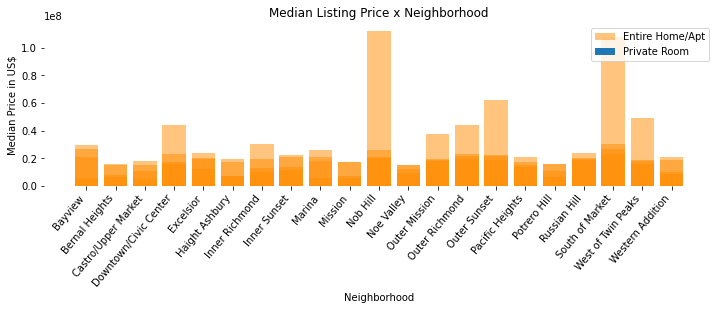

In [75]:
y_df_rm = y_df[y_df['room_type'] == 'Pvt Rm']

f, ax = plt.subplots(figsize=(12, 3))
plt.xticks(rotation=50, size=10, ha='right')

plt.bar(height="Median Price (US$)", x="index", data=y_df, label="Total", alpha = 0.5, color="darkorange")
plt.bar(height="Median Price (US$)", x="index", data=y_df_rm, label="Total", alpha = 0.5, color="deepskyblue")

sns.despine(left=True, bottom=True)
plt.legend(['Entire Home/Apt', 'Private Room'], loc=1)
plt.title(label='Median Listing Price x Neighborhood')
plt.xlabel("Neighborhood")
plt.ylabel("Median Price in US$")
plt.show()

#### Neighborhoods with high median listing prices include: Pacific Heights, Marina, Portrero Hill, Castro, South of Market, Western Addition, and Russian Hill.

In [76]:
# Calculate the total number of neighborhoods
neighborhood_count = df["neighborhood"].unique()
neighborhood_count

array(['Western Addition', 'Inner Sunset', 'Bernal Heights',
       'Haight Ashbury', 'Mission', 'Potrero Hill', 'Nob Hill',
       'Downtown/Civic Center', 'Castro/Upper Market', 'South of Market',
       'Noe Valley', 'Outer Richmond', 'Pacific Heights', 'Russian Hill',
       'Outer Sunset', 'Marina', 'Inner Richmond', 'Excelsior',
       'West of Twin Peaks', 'Bayview', 'Outer Mission'], dtype=object)

In [77]:
per_zipcode = df.groupby(["zipcode"]).count()["neighborhood"]
per_zipcode

zipcode
94102    240
94103    376
94104      1
94105     77
94107    300
94108     42
94109    469
94110    890
94112    267
94114    565
94115    251
94116     66
94117    536
94118    180
94121    189
94122    330
94123    185
94124    174
94127    117
94129      1
94131    148
94133     73
94134     69
94158     72
Name: neighborhood, dtype: int64

In [78]:
# Calculate the total number of property types
property_count = df["property_type"].unique()
property_count

array(['Apartment', 'House', 'Condominium', 'Guest suite'], dtype=object)

In [79]:
# Calculate the total number of room types
room_count = df["room_type"].unique()
room_count

array(['Entire home/apt', 'Private room'], dtype=object)

In [80]:
# Calculate the Average prices for: "price", "cleaning_fee"
average_price = df["price"].mean()
average_price

197.45728017087933

In [81]:
average_cleaning_fee = df["cleaning_fee"].mean()
average_cleaning_fee

97.95389818440727

In [82]:
# Calculate the average price per neighborhood
per_neighborhood = df.groupby(["neighborhood"]).mean()["price"]
per_neighborhood

neighborhood
Bayview                 119.294
Bernal Heights          187.326
Castro/Upper Market     236.090
Downtown/Civic Center   155.553
Excelsior               129.244
Haight Ashbury          217.135
Inner Richmond          220.036
Inner Sunset            188.845
Marina                  260.343
Mission                 196.476
Nob Hill                165.424
Noe Valley              231.120
Outer Mission           151.437
Outer Richmond          187.971
Outer Sunset            142.568
Pacific Heights         285.148
Potrero Hill            219.814
Russian Hill            255.938
South of Market         208.455
West of Twin Peaks      171.771
Western Addition        206.829
Name: price, dtype: float64

In [83]:
# Calculate the average cleaning fee per neighborhood
per_neighborhood_cf = df.groupby(["neighborhood"]).mean()["cleaning_fee"]
per_neighborhood_cf

neighborhood
Bayview                  71.683
Bernal Heights           94.123
Castro/Upper Market      99.517
Downtown/Civic Center    76.830
Excelsior                66.335
Haight Ashbury          101.042
Inner Richmond          104.278
Inner Sunset             91.103
Marina                  136.729
Mission                 100.358
Nob Hill                 93.667
Noe Valley              109.530
Outer Mission            81.759
Outer Richmond           97.532
Outer Sunset             75.950
Pacific Heights         124.830
Potrero Hill            102.088
Russian Hill            118.829
South of Market         110.088
West of Twin Peaks       93.298
Western Addition        103.008
Name: cleaning_fee, dtype: float64

In [84]:
# Calculate the average price per property type
per_property = df.groupby(["property_type"]).mean()["price"]
per_property

property_type
Apartment     184.018
Condominium   241.812
Guest suite   161.432
House         208.521
Name: price, dtype: float64

In [85]:
# Calculate the average cleaning fee per property type
per_pt_cf = df.groupby(["property_type"]).mean()["cleaning_fee"]
per_pt_cf

property_type
Apartment     100.203
Condominium   102.808
Guest suite    79.000
House          97.576
Name: cleaning_fee, dtype: float64

In [86]:
# Calculate the average price per room type
per_room = df.groupby(["room_type"]).mean()["price"]
per_room

room_type
Entire home/apt   244.973
Private room      110.629
Name: price, dtype: float64

In [87]:
# Calculate the average cleaning fee per room type
per_room_cf = df.groupby(["room_type"]).mean()["cleaning_fee"]
per_room_cf

room_type
Entire home/apt   122.448
Private room       53.194
Name: cleaning_fee, dtype: float64

In [88]:
# Determine the Neighborhood
per_ngh = df.set_index(["neighborhood"])

per_ngh_df = pd.DataFrame({
    "Average Price": per_neighborhood,
    "Average Cleaning Fee": per_neighborhood_cf})

per_ngh_df["Average Price"] = per_ngh_df["Average Price"].map("{:.1f}".format)
per_ngh_df["Average Cleaning Fee"] = per_ngh_df["Average Cleaning Fee"].map("{:.1f}".format)

per_ngh_df

,Average Price,Average Cleaning Fee
neighborhood,,
Bayview,119.3,71.7
Bernal Heights,187.3,94.1
Castro/Upper Market,236.1,99.5
Downtown/Civic Center,155.6,76.8
Excelsior,129.2,66.3
Haight Ashbury,217.1,101.0
Inner Richmond,220.0,104.3
Inner Sunset,188.8,91.1
Marina,260.3,136.7


In [89]:
# Determine the Property Type
per_prt = df.set_index(["property_type"])

per_prt = pd.DataFrame({
    "Average Price": per_property,
    "Average Cleaning Fee": per_pt_cf})

per_prt["Average Price"] = per_prt["Average Price"].map("{:.1f}".format)
per_prt["Average Cleaning Fee"] = per_prt["Average Cleaning Fee"].map("{:.1f}".format)


per_prt

,Average Price,Average Cleaning Fee
property_type,,
Apartment,184.0,100.2
Condominium,241.8,102.8
Guest suite,161.4,79.0
House,208.5,97.6


In [90]:
# Determine the Room Type
per_rt = df.set_index(["room_type"])

per_rt = pd.DataFrame({
    "Average Price": per_room,
    "Average Cleaning Fee": per_room_cf})

per_rt["Average Price"] = per_rt["Average Price"].map("{:.1f}".format)
per_rt["Average Cleaning Fee"] = per_rt["Average Cleaning Fee"].map("{:.1f}".format)

per_rt

,Average Price,Average Cleaning Fee
room_type,,
Entire home/apt,245.0,122.4
Private room,110.6,53.2


In [94]:
# Establish the bins.
new_size_bins = [0, 50, 100, 200, 300, 400]
new_group_names = ["Cheapeast (<50)", "Affordable (50-100)", " Normal (100-200)", "Medium (200-300)", "Expensive (300-400)"]
# Categorize spending based on the bins.
df["Neighborhood"] = pd.cut(df["price"], new_size_bins, labels = new_group_names)

df

,room_id,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total,Neighborhood
0,958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.000,1.000,1,30,37.769,-122.434,217,97.000,170.000,100.000,270.000,Normal (100-200)
1,3850,4921,t,House,Private room,Inner Sunset,94131,2,1.000,1.000,1,5,37.754,-122.458,160,94.000,99.000,10.000,109.000,Affordable (50-100)
2,5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.000,1.000,30,60,37.745,-122.421,111,98.000,235.000,100.000,335.000,Medium (200-300)
3,7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,60,37.767,-122.453,18,86.000,65.000,50.000,115.000,Affordable (50-100)
4,8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.000,4.000,32,90,37.765,-122.452,8,93.000,65.000,50.000,115.000,Affordable (50-100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7808,39318438,272084446,f,Apartment,Entire home/apt,Mission,94110,4,0.000,1.000,2,1125,37.760,-122.412,0,0.000,250.000,0.000,250.000,Medium (200-300)
7809,39335839,263550277,f,House,Private room,Bernal Heights,94110,2,1.000,1.000,2,7,37.740,-122.414,0,0.000,150.000,60.000,210.000,Normal (100-200)
7810,39337552,4996407,f,Guest suite,Entire home/apt,Haight Ashbury,94117,4,1.000,1.000,2,1125,37.772,-122.437,0,0.000,113.000,75.000,188.000,Normal (100-200)
7812,39343373,245447609,f,Condominium,Entire home/apt,Downtown/Civic Center,94102,4,1.000,1.000,1,7,37.778,-122.422,0,0.000,200.000,0.000,200.000,Normal (100-200)
